In [62]:
import os
import pandas as pd
import xml.etree.ElementTree as et
import librosa
import librosa.display
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
from tqdm import tqdm

In [88]:
ANNOTATION_PATH = '../data/IDMT-SMT-GUITAR_V2/dataset2/annotation'
AUDIO_PATH_ROOT = '../data/IDMT-SMT-GUITAR_V2/dataset2/audio'

In [89]:
annotation_files = os.listdir(ANNOTATION_PATH)
annotation_files.sort()
len(annotation_files)

87

In [90]:
dataset = pd.DataFrame()
for i, annotation_file in tqdm(enumerate(annotation_files)):
    annotation_file_path = os.path.join(ANNOTATION_PATH, annotation_file)

    annotation_tree = et.parse(annotation_file_path)
    annotation_root = annotation_tree.getroot()
    global_params = annotation_root.find('globalParameter')
    transcription = annotation_root.find('transcription')

    params = []
    params_value = []
    for param in global_params:
        params.append(param.tag)
        params_value.append(param.text)
    params_value[0] = annotation_file[:-3] + 'wav'

    total_event = len(transcription.findall('event'))
    df_globalParams = pd.DataFrame([params_value]*total_event, columns=params)

    transcription_tag = ['expressionStyle', 'excitationStyle', 'onsetSec', 'offsetSec', 'duration']
    df_transcription = pd.DataFrame(columns=transcription_tag)
    for tag in transcription_tag:
        if tag != 'duration':
            values = []
            for value in transcription.iter(tag):
                values.append(value.text)
            df_transcription[tag] = values
    df = pd.concat([df_transcription, df_globalParams], axis=1)
    if i == 0:
        dataset = df
    else:
        dataset = dataset.append(df)
dataset = dataset.reset_index(drop=True)
dataset['onsetSec'] = pd.to_numeric(dataset['onsetSec'])
dataset['offsetSec'] = pd.to_numeric(dataset['offsetSec'])
dataset['duration'] = dataset['offsetSec'] - dataset['onsetSec']

# idx = []
# for i in range(dataset.shape[0]):
#     if (('Lick' in dataset['audioFileName'][i]) and ((dataset['expressionStyle'][i] == 'NO') and (dataset['excitationStyle'][i] != 'FS'))) or (dataset['excitationStyle'][i] == 'MU'):
#         idx.append(i)
# dataset = dataset.drop(idx)
# dataset = dataset.reset_index(drop=True)

87it [00:00, 87.84it/s]


In [91]:
print(dataset.shape)
dataset

(1572, 15)


,expressionStyle,excitationStyle,onsetSec,offsetSec,duration,audioFileName,instrument,instrumentModel,pickUpSetting,instrumentTuning,recordingDate,recordingArtist,instrumentBodyMaterial,instrumentStringMaterial,composer
0,NO,PK,1.5790,2.2409,0.6619,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
1,NO,PK,2.6026,3.3066,0.7040,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
2,NO,PK,3.6949,4.3970,0.7021,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
3,NO,PK,4.7456,5.4846,0.7390,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
4,NO,PK,5.8514,6.5035,0.6521,AR_A_fret_0-20.wav,EGUI,Aristides 010,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,VI,PK,43.0498,48.6289,5.5791,LP_V_vibrato_slow-fast.wav,EGUI,Gibson Les Paul,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
1568,VI,PK,49.6065,54.7807,5.1742,LP_V_vibrato_slow-fast.wav,EGUI,Gibson Les Paul,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
1569,VI,PK,55.5450,61.3962,5.8512,LP_V_vibrato_slow-fast.wav,EGUI,Gibson Les Paul,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling
1570,VI,PK,62.3891,66.6713,4.2822,LP_V_vibrato_slow-fast.wav,EGUI,Gibson Les Paul,unknown,40 45 50 55 59 64,13-02-14,Christian Kehling,unknown,Steel,Christian Kehling


In [92]:
expressionStyle = pd.value_counts(dataset['expressionStyle']).reset_index()
expressionStyle.columns = ['Expression Style', 'Number']
px.bar(expressionStyle, x='Expression Style', y='Number', width=400, height=300)

In [93]:
expressionStyle = pd.value_counts(dataset['excitationStyle']).reset_index()
expressionStyle.columns = ['Expression Style', 'Number']
px.bar(expressionStyle, x='Expression Style', y='Number', width=400, height=300)

In [97]:
expressionStyle = pd.value_counts(dataset[dataset['excitationStyle'] == 'FS']['expressionStyle']).reset_index()
expressionStyle.columns = ['Expression Style', 'Number']
px.bar(expressionStyle, x='Expression Style', y='Number', width=400, height=300)

In [99]:
def get_features(path, start_time, duration, sr=22050, n_mfcc=13, mode='mirror', n_fft=2048):
    signal, sr = librosa.load(path, sr=sr, offset=start_time, duration=duration)

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    delta_mfcc = librosa.feature.delta(mfcc, mode=mode)
    delta2_mfcc = librosa.feature.delta(mfcc, mode=mode, order=2)

    mfccs = np.hstack((
                    np.mean(mfcc, axis=1),
                    np.std(mfcc, axis=1),
                    skew(mfcc, axis=1),
                    kurtosis(mfcc, axis=1)
                ))
    delta_mfccs = np.hstack((
                    np.mean(delta_mfcc, axis=1),
                    np.std(delta_mfcc, axis=1),
                    skew(delta_mfcc, axis=1),
                    kurtosis(delta_mfcc, axis=1)
                ))
    delta2_mfccs = np.hstack((
                    np.mean(delta2_mfcc, axis=1),
                    np.std(delta2_mfcc, axis=1),
                    skew(delta2_mfcc, axis=1),
                    kurtosis(delta2_mfcc, axis=1)
                ))

    extracted_features = np.hstack((mfccs, delta_mfccs, delta2_mfccs))
    return extracted_features

In [100]:
data = []
for i in tqdm(range(dataset.shape[0])):
    filename = dataset['audioFileName'][i]
    expression_style = dataset['expressionStyle'][i]
    excitation_style = dataset['excitationStyle'][i]
    onset = dataset['onsetSec'][i]
    duration = dataset['duration'][i]
    audio_path = os.path.join(AUDIO_PATH_ROOT, filename)

    if duration >= 0.1:
        features = get_features(audio_path, onset, duration)
        features = np.append(features, [expression_style, excitation_style, onset, duration, filename])
        data.append(features)

100%|██████████| 1572/1572 [03:27<00:00,  7.56it/s]


In [104]:
columns = []
names = ['mfcc', 'delta_mfcc', 'delta2_mfcc']
stats = ['mean', 'std', 'skew', 'kurtosis']
file_desc = ['expression_style', 'excitation_style', 'start_time', 'duration', 'filename']

for name in names:
    for stat in stats:
        for i in range(13):
            col = f'{stat}_{name}_{i+1}'
            columns = np.append(columns, col)

columns = np.append(columns, file_desc)
my_dataset = pd.DataFrame(data, columns=columns)
my_dataset['style'] = my_dataset['expression_style'] + '-' + my_dataset['excitation_style']
my_dataset

,mean_mfcc_1,mean_mfcc_2,mean_mfcc_3,mean_mfcc_4,mean_mfcc_5,mean_mfcc_6,mean_mfcc_7,mean_mfcc_8,mean_mfcc_9,mean_mfcc_10,...,kurtosis_delta2_mfcc_10,kurtosis_delta2_mfcc_11,kurtosis_delta2_mfcc_12,kurtosis_delta2_mfcc_13,expression_style,excitation_style,start_time,duration,filename,style
0,-373.5208,262.5744,7.9024234,-34.80873,9.961049,-8.05357,-15.143747,14.34315,2.7225041,-38.14924,...,1.8095074,1.1381006,1.9208298,-1.0720413,NO,PK,1.579,0.6618999999999999,AR_A_fret_0-20.wav,NO-PK
1,-393.7246,245.06755,31.624142,-31.783554,0.7108597,4.8498893,-2.2053814,6.3326335,-5.7031603,-35.125965,...,2.1845546,1.1553125,1.1351824,4.058322,NO,PK,2.6026,0.7040000000000002,AR_A_fret_0-20.wav,NO-PK
2,-398.9016,239.59203,20.337126,-26.77444,2.9335093,-8.322906,-12.972422,9.559001,2.3934262,-30.408892,...,1.2832727,0.7862222,-0.06454539,0.64522743,NO,PK,3.6949,0.7021000000000002,AR_A_fret_0-20.wav,NO-PK
3,-420.00146,229.10434,22.062202,-32.40053,4.5379567,2.5234015,-12.783854,-0.54324985,-6.998987,-36.2475,...,1.6813421,1.0357203,0.623852,2.8943124,NO,PK,4.7456,0.7390000000000008,AR_A_fret_0-20.wav,NO-PK
4,-396.9219,223.9797,22.618193,-27.90899,-2.7065167,-10.108872,-16.10841,3.1485534,1.6159302,-23.154861,...,0.19434929,0.6151891,0.47414136,-0.09984326,NO,PK,5.8514,0.6520999999999999,AR_A_fret_0-20.wav,NO-PK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,-606.9015,83.29488,22.430635,7.277141,1.10458,-3.615564,-2.8690424,-2.9695876,-4.2643905,-6.809227,...,0.8957958,1.2389703,1.2796998,0.071035385,VI,PK,43.0498,5.579100000000004,LP_V_vibrato_slow-fast.wav,VI-PK
1544,-606.1899,91.671684,16.500425,12.4722805,9.33945,-4.2222204,-9.818228,-5.5479083,-5.8694,-5.5707326,...,-0.29434013,0.017796993,3.5983968,1.8744073,VI,PK,49.6065,5.174200000000006,LP_V_vibrato_slow-fast.wav,VI-PK
1545,-613.2374,80.50335,15.800746,9.415098,2.4714391,-11.1929,-15.8869505,-10.32773,-11.864934,-10.859158,...,2.8008027,0.3815589,0.46684217,0.017703056,VI,PK,55.545,5.851199999999999,LP_V_vibrato_slow-fast.wav,VI-PK
1546,-584.2645,98.81721,0.6656316,1.0583072,6.641749,-3.675886,-7.5781255,-8.488941,-7.3033667,-3.455103,...,0.3278625,0.57649946,-0.57495594,2.4794607,VI,PK,62.3891,4.282200000000003,LP_V_vibrato_slow-fast.wav,VI-PK


In [108]:
my_dataset.to_csv('../data/idmt-smt-guitar2.csv', index=False)

0.8838709677419355
0.8145129222494223
              precision    recall  f1-score   support

          BE       0.83      0.62      0.71        24
          DN       1.00      1.00      1.00        45
          HA       1.00      0.96      0.98        26
          NO       0.86      0.99      0.92       175
          SL       0.67      0.25      0.36        16
          VI       0.79      0.46      0.58        24

    accuracy                           0.88       310
   macro avg       0.86      0.71      0.76       310
weighted avg       0.88      0.88      0.87       310



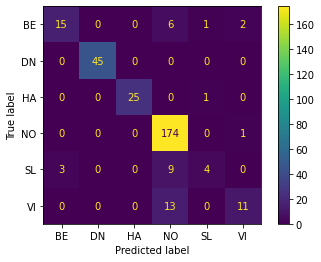

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, matthews_corrcoef, classification_report
import matplotlib.pyplot as plt

df = my_dataset
df['style'] = df['expression_style'] + '-' + df['excitation_style']
X = df.iloc[:,:156]
y = df['expression_style']
y_sub = df['style']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y_sub)

scaler = MinMaxScaler(feature_range=(-1,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c=3
s=3
clf = SVC(kernel='rbf', C=2**c, gamma=1/(2*(2**s)**2), decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(matthews_corrcoef(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test)